In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
ticker = "^IPSA"

In [3]:
data = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.DataFrame(data)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-02,1183.150024,1188.479980,1183.150024,1185.750000,1185.750000,0
2002-01-03,1185.750000,1196.880005,1185.520020,1195.930054,1195.930054,0
2002-01-04,1195.930054,1211.189941,1195.099976,1203.380005,1203.380005,0
2002-01-07,1204.329956,1204.329956,1186.939941,1188.949951,1188.949951,0
2002-01-08,1188.949951,1190.130005,1167.890015,1168.010010,1168.010010,0
...,...,...,...,...,...,...
2019-06-10,4951.129883,5019.779785,4951.129883,5018.990234,5018.990234,0
2019-06-11,5018.990234,5093.939941,5018.990234,5069.240234,5069.240234,0
2019-06-12,5069.229980,5085.790039,5057.109863,5067.850098,5067.850098,0


Text(0, 0.5, 'Price')

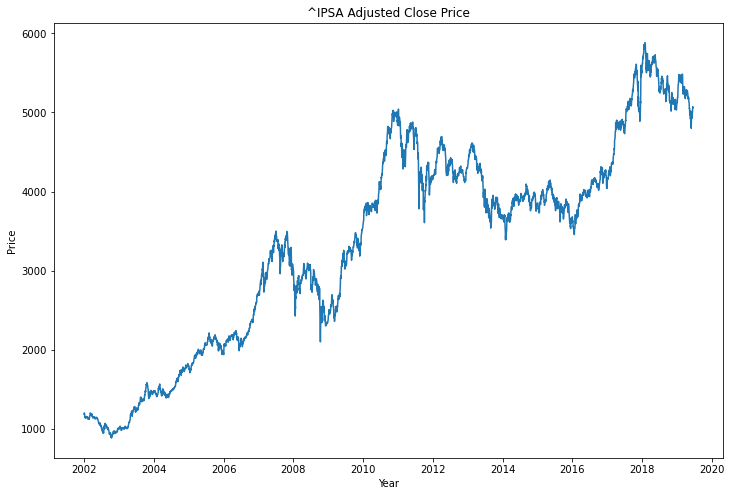

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(df["Adj Close"])
plt.title(f"{ticker} Adjusted Close Price")
plt.xlabel('Year')
plt.ylabel('Price')

In [6]:
len(df)

4346

In [7]:
q_80 = int(len(df) * .8)
q_90 = int(len(df) * .9)

In [8]:
y_train = df["Adj Close"].iloc[:q_80]
y_val = df["Adj Close"].iloc[q_80: q_90]
y_test = df["Adj Close"].iloc[q_90:]

<AxesSubplot:xlabel='Date'>

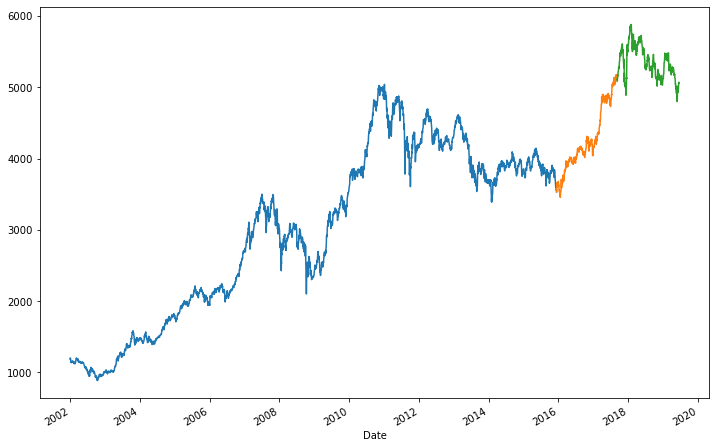

In [9]:
y_train.plot(figsize = (12, 8))
y_val.plot()
y_test.plot()

In [10]:
from tensorflow.keras.models import Sequential

In [11]:
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from tensorflow.keras.optimizers import Adam

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
length = 8
batch_size = 1

In [16]:
generator = TimeseriesGenerator(y_train, y_train, length = length, batch_size = batch_size)

In [17]:
validation_generator = TimeseriesGenerator(y_val, y_val, length = length, batch_size = batch_size)

In [18]:
test_generator = TimeseriesGenerator(y_test, y_test, length = length, batch_size = batch_size)

In [19]:
es = EarlyStopping(monitor = "val_loss", patience = 5)

In [20]:
n_features = 1

In [21]:
m = Sequential()

m.add(LSTM(64, input_shape = (length, n_features), activation = "relu", return_sequences = False))

m.add(Dense(8, activation = "relu"))

m.add(Dense(1, activation = "linear"))

m.compile(optimizer = Adam(learning_rate = .0001), loss = "mse", metrics = ["mean_absolute_error"])

In [22]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [23]:
m.fit_generator(generator, epochs = 50, validation_data = validation_generator, callbacks = [es])

Epoch 1/50


C:\Users\User\AppData\Local\Temp\ipykernel_3044\1446656313.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  m.fit_generator(generator, epochs = 50, validation_data = validation_generator, callbacks = [es])


3468/3468 [==============================] - 12s 3ms/step - loss: 1791023.6250 - mean_absolute_error: 721.6033 - val_loss: 2824.4426 - val_mean_absolute_error: 41.7007
Epoch 2/50
3468/3468 [==============================] - 10s 3ms/step - loss: 3184.8599 - mean_absolute_error: 37.2138 - val_loss: 2234.4949 - val_mean_absolute_error: 36.3988
Epoch 3/50
3468/3468 [==============================] - 29s 8ms/step - loss: 4279.6997 - mean_absolute_error: 40.6117 - val_loss: 2536.9482 - val_mean_absolute_error: 39.1395
Epoch 4/50
3468/3468 [==============================] - 31s 9ms/step - loss: 2801.0610 - mean_absolute_error: 37.2909 - val_loss: 4254.2979 - val_mean_absolute_error: 55.9846
Epoch 5/50
3468/3468 [==============================] - 32s 9ms/step - loss: 3337.0261 - mean_absolute_error: 41.3052 - val_loss: 2221.4424 - val_mean_absolute_error: 36.1685
Epoch 6/50
3468/3468 [==============================] - 32s 9ms/step - loss: 3402.6997 - mean_absolute_error: 40.6608 - val_loss: 46

<AxesSubplot:>

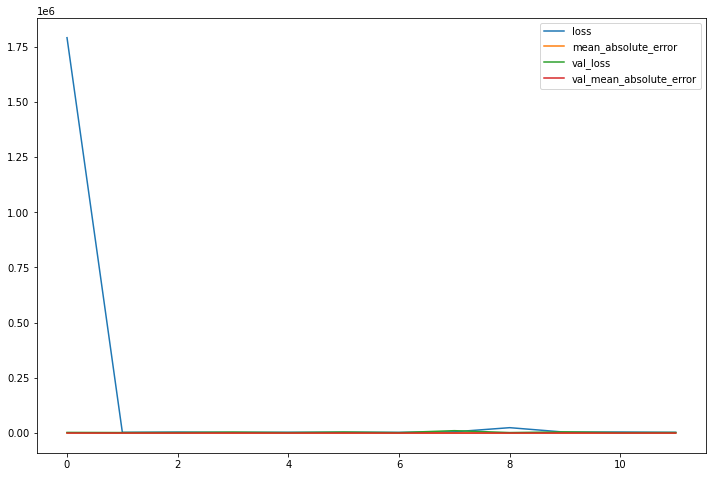

In [24]:
losses = pd.DataFrame(m.history.history)
losses.plot(figsize = (12, 8))

In [25]:
y_hat_train = m.predict(generator).flatten()
y_hat_train.shape

3468/3468 [==============================] - 6s 2ms/step


(3468,)

In [26]:
y_train.shape

(3476,)

<AxesSubplot:xlabel='Date'>

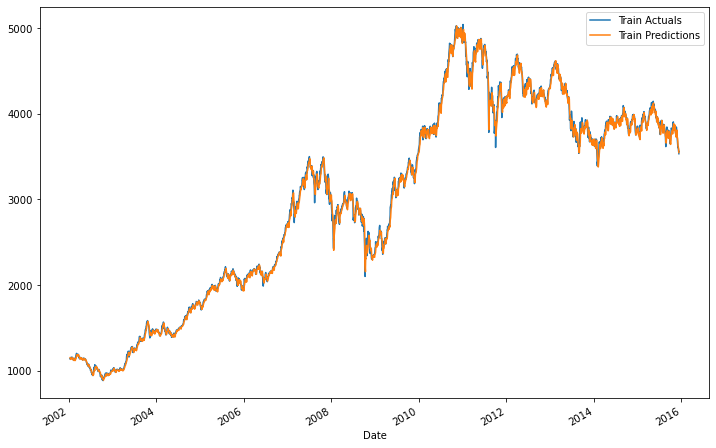

In [27]:
train_df = pd.DataFrame(data = {"Train Actuals": y_train.iloc[length:].values.flatten(), "Train Predictions": y_hat_train}, index = y_train.iloc[length:].index)
train_df.plot(figsize = (12, 8))

<AxesSubplot:xlabel='Date'>

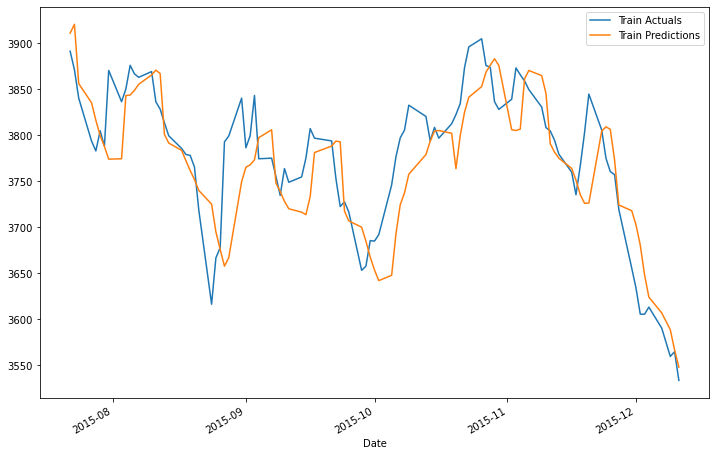

In [28]:
train_df.iloc[-100:].plot(figsize = (12, 8))

In [29]:
y_hat_val = m.predict(validation_generator).flatten()

427/427 [==============================] - 1s 1ms/step


<AxesSubplot:xlabel='Date'>

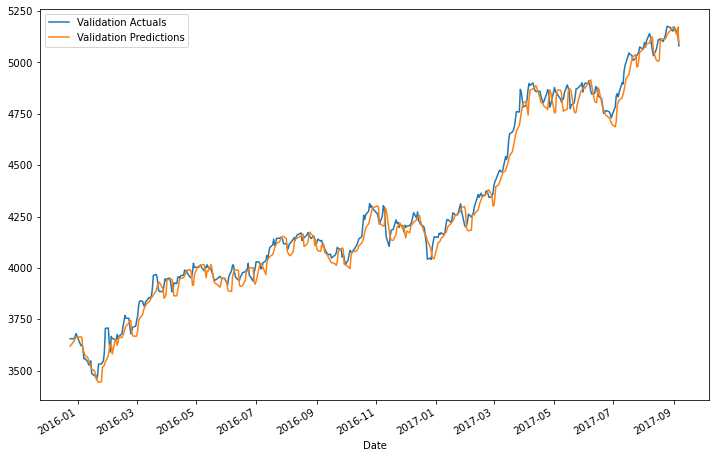

In [30]:
val_df = pd.DataFrame(data = {"Validation Actuals": y_val.iloc[length:].values.flatten(), "Validation Predictions": y_hat_val}, index = y_val.iloc[length:].index)
val_df.plot(figsize = (12, 8))

<AxesSubplot:xlabel='Date'>

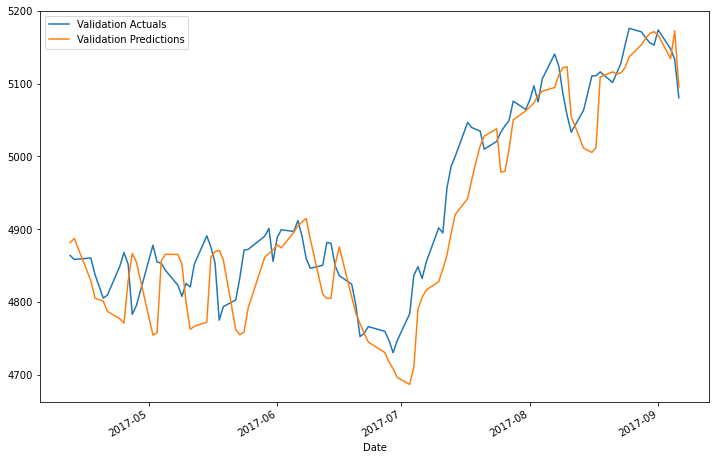

In [31]:
val_df.iloc[-100:].plot(figsize = (12, 8))

In [32]:
y_hat_test = m.predict(test_generator).flatten()

427/427 [==============================] - 1s 1ms/step


<AxesSubplot:xlabel='Date'>

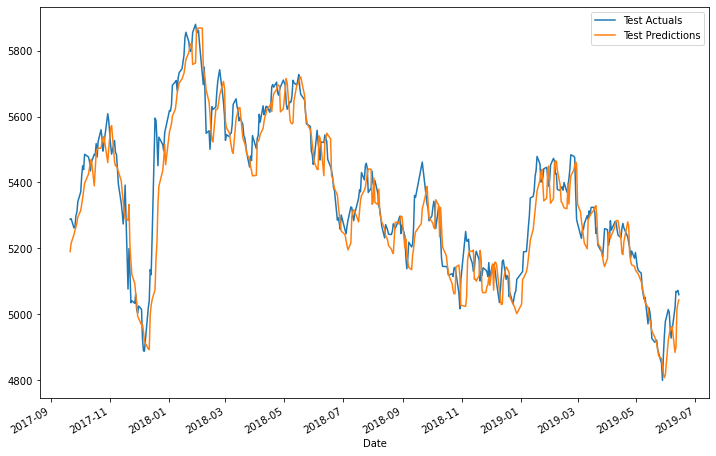

In [33]:
test_df = pd.DataFrame(data = {"Test Actuals": y_test.iloc[length:].values.flatten(), "Test Predictions": y_hat_test}, index = y_test.iloc[length:].index)
test_df.plot(figsize = (12, 8))

<AxesSubplot:xlabel='Date'>

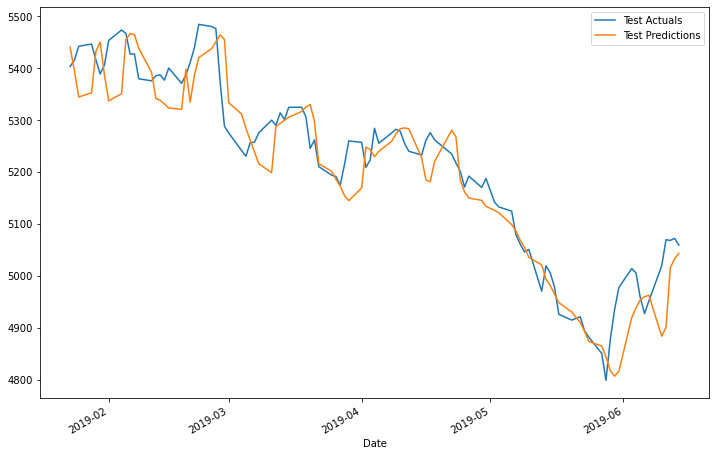

In [34]:
test_df.iloc[-100:].plot(figsize = (12, 8))

<AxesSubplot:xlabel='Date'>

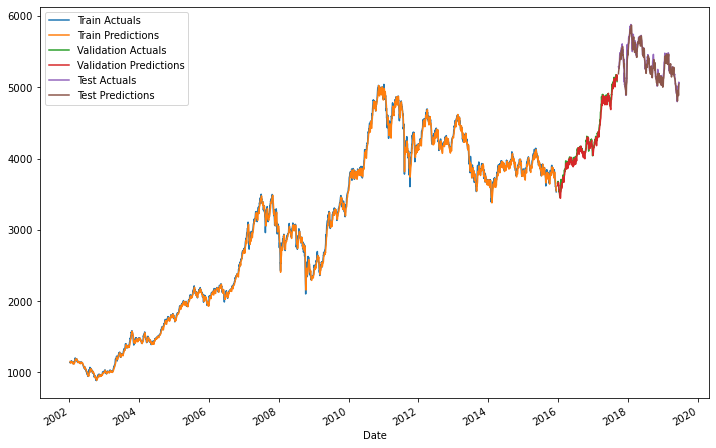

In [35]:
ax = train_df.plot(figsize = (12, 8))
val_df.plot(ax = ax)
test_df.plot(ax = ax)

### Forecast

In [36]:
m = Sequential()

m.add(LSTM(64, input_shape = (length, n_features), activation = "relu", return_sequences = False))

m.add(Dense(8, activation = "relu"))

m.add(Dense(1, activation = "linear"))

m.compile(optimizer = Adam(learning_rate = .0001), loss = "mse", metrics = ["mean_absolute_error"])

In [37]:
full_generator = TimeseriesGenerator(df["Adj Close"], df["Adj Close"], length = length, batch_size = batch_size)

In [38]:
m.fit_generator(full_generator, epochs = es.stopped_epoch)

Epoch 1/11


C:\Users\User\AppData\Local\Temp\ipykernel_3044\3418163387.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  m.fit_generator(full_generator, epochs = es.stopped_epoch)


4338/4338 [==============================] - 13s 3ms/step - loss: 1401581.0000 - mean_absolute_error: 547.5657
Epoch 2/11
4338/4338 [==============================] - 12s 3ms/step - loss: 6265.2148 - mean_absolute_error: 56.6123
Epoch 3/11
4338/4338 [==============================] - 14s 3ms/step - loss: 7074.4189 - mean_absolute_error: 57.7745
Epoch 4/11
4338/4338 [==============================] - 32s 7ms/step - loss: 8936.4482 - mean_absolute_error: 61.5315
Epoch 5/11
4338/4338 [==============================] - 29s 7ms/step - loss: 6898.1299 - mean_absolute_error: 59.3967
Epoch 6/11
4338/4338 [==============================] - 27s 6ms/step - loss: 7016.8647 - mean_absolute_error: 60.5014
Epoch 7/11
4338/4338 [==============================] - 25s 6ms/step - loss: 6854.4619 - mean_absolute_error: 59.7360
Epoch 8/11
4338/4338 [==============================] - 25s 6ms/step - loss: 6731.6919 - mean_absolute_error: 58.9119
Epoch 9/11
4338/4338 [==============================] - 22s 5ms

In [39]:
y_forecast = []

first_eval_batch = df["Adj Close"][-length:].values
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    current_pred = m.predict(current_batch)[0]
    y_forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 32ms/step


In [40]:
forecast_index = pd.date_range(start = df.index[-1], periods = length, freq = "B")

In [42]:
forecast_df = pd.DataFrame(data = y_forecast, index = forecast_index, columns = [f"{ticker} Price Forecast"])

<AxesSubplot:xlabel='Date'>

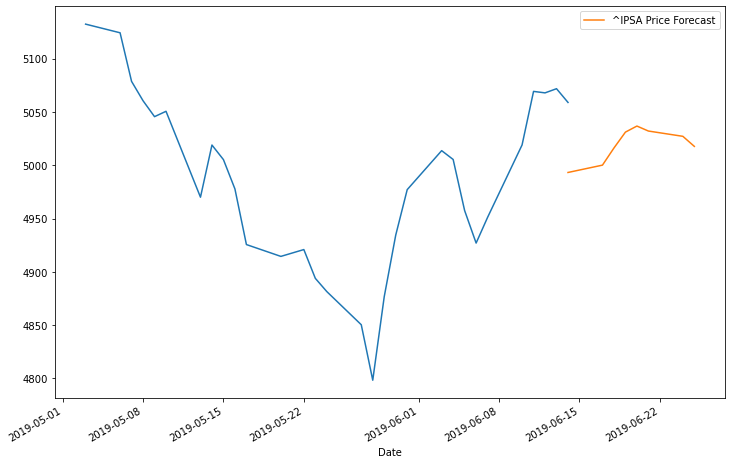

In [43]:
ax = df["Adj Close"].iloc[-30:].plot(figsize = (12, 8))
forecast_df.plot(ax = ax)

In [44]:
from tensorflow.keras.utils import plot_model

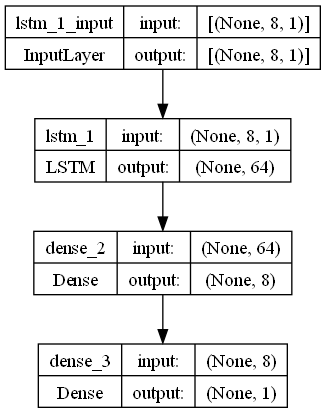

In [45]:
plot_model(m, f"LSTM_for_{ticker}_Stock.png", show_shapes = True)

In [46]:
m.save(f"LSTM_for_{ticker}_Stock.h5")